## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing the necessary libraries**

In [ ]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install numpy==1.26.4 \
             scikit-learn==1.6.1 \
             scipy==1.13.1 \
             gensim==4.3.3 \
             sentence-transformers==3.4.1 \
             pandas==2.2.2

Note:
- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [ ]:
#Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Set plot style
sns.set_style('whitegrid')

## **Loading the dataset**

In [ ]:
# Load the dataset
stock = pd.read_csv('stock_news.csv')

#Create a copy of stock dataset
stock_data = stock.copy()

## **Data Overview**
#### This section provides an overview of the dataset including its shape, column data types, statistical summary, as well as information on missing and duplicate values

In [ ]:
# Display the size of the dataset (number of rows and columns)
print("Size of the dataset (rows, columns):", stock_data.shape)

Size of the dataset (rows, columns): (349, 8)


In [ ]:
# Display the first 5 rows of the dataset and make sure the full text of the news column is visible

# Set option to display full column content
pd.set_option('display.max_colwidth', None)

# Display the first 5 rows
print("First 5 rows of the dataset (with complete values):")
display(stock_data.head())

# Reset option to default
pd.reset_option('display.max_colwidth')

First 5 rows of the dataset (with complete values):


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,"Apple lowered its fiscal Q1 revenue guidance to $84 billion from earlier estimates of $89-$93 billion due to weaker than expected iPhone sales. The announcement caused a significant drop in Apple's stock price and negatively impacted related suppliers, leading to broader market declines for tech indices such as Nasdaq 10",41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,"Apple cut its fiscal first quarter revenue forecast from $89-$93 billion to $84 billion due to weaker demand in China and fewer iPhone upgrades. CEO Tim Cook also mentioned constrained sales of Airpods and Macbooks. Apple's shares fell 8.5% in post market trading, while Asian suppliers like Hon",41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,"This news article reports that yields on long-dated U.S. Treasury securities hit their lowest levels in nearly a year on January 2, 2019, due to concerns about the health of the global economy following weak economic data from China and Europe, as well as the partial U.S. government shutdown. Apple",41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,"Apple's revenue warning led to a decline in USD JPY pair and a gain in Japanese yen, as investors sought safety in the highly liquid currency. Apple's underperformance in Q1, with forecasted revenue of $84 billion compared to analyst expectations of $91.5 billion, triggered risk aversion mood in markets",41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
# Display data types and non-null counts

print("Data types and non-null counts:") #Title
print("\n") #New line
display(stock_data.info())

Data types and non-null counts:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


None

In [ ]:
# Display descriptive statistics of the dataset
print("\nStatistical summary of the stock dataset:")
display(stock_data.describe().T)


Statistical summary of the stock dataset:


,count,mean,std,min,25%,50%,75%,max
Open,349.0,4.622923e+01,6.442817e+00,3.756750e+01,4.174000e+01,4.597500e+01,5.070750e+01,6.681750e+01
High,349.0,4.670046e+01,6.507321e+00,3.781750e+01,4.224500e+01,4.602500e+01,5.085000e+01,6.706250e+01
Low,349.0,4.574539e+01,6.391976e+00,3.730500e+01,4.148250e+01,4.564000e+01,4.977750e+01,6.586250e+01
Close,349.0,4.492632e+01,6.398338e+00,3.625413e+01,4.024691e+01,4.459692e+01,4.911079e+01,6.480523e+01
Volume,349.0,1.289482e+08,4.317031e+07,4.544800e+07,1.032720e+08,1.156272e+08,1.511252e+08,2.444392e+08
Label,349.0,-5.444126e-02,7.151192e-01,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
# Convert 'Date' column from object to datetime format
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Display the data types after conversion
print("Data types after converting 'Date' to datetime:")
print("\n") #New line
display(stock_data.info())

Data types after converting 'Date' to datetime:


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


None

In [ ]:
# Check for duplicate rows
duplicate_rows = stock_data.duplicated().sum()

print(f"Number of duplicate rows in the dataset: {duplicate_rows}")

Number of duplicate rows in the dataset: 0


In [ ]:
# Check for missing values
missing_values = stock_data.isnull().sum()

print("Missing values per column:")
display(missing_values)

Missing values per column:


,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


## **Exploratory Data Analysis**

### **Univariate Analysis**

* Distribution of individual variables
* Compute and check the distribution of the length of news content

###### **Count plot representing label distribution in %**

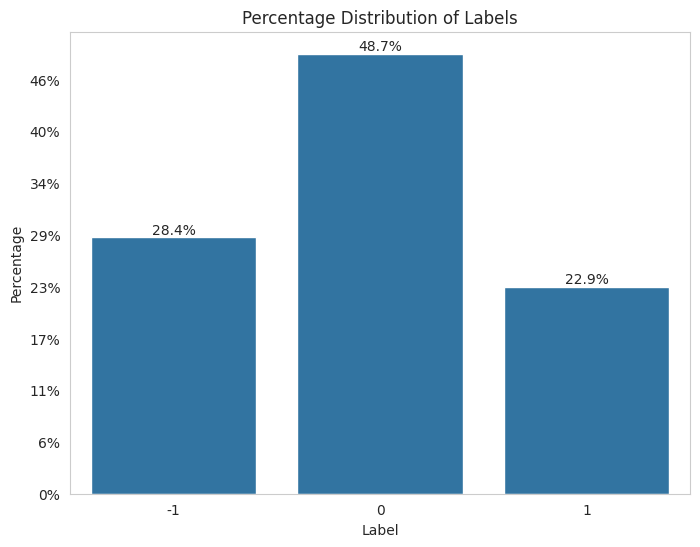

In [ ]:
# Calculate the percentage of each label
label_counts = stock_data['Label'].value_counts()
label_percentages = label_counts / len(stock_data) * 100

# Visualize the percentage of each label
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Label', data=stock_data)
plt.title('Percentage Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Percentage')

# Remove grid lines
plt.grid(False)

# Display percentages on top of each bar
for i, p in enumerate(ax.patches):
    height = p.get_height()
    # Get the label value directly from the x-tick labels
    label_value = int(ax.get_xticklabels()[i].get_text())
    percentage = label_percentages[label_value]
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Change y-axis to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y / len(stock_data) * 100)))

plt.show()

###### **Box plots representing the distribution of numerical variables: Open, High, Low, Close, Volume**

Distribution of Open:


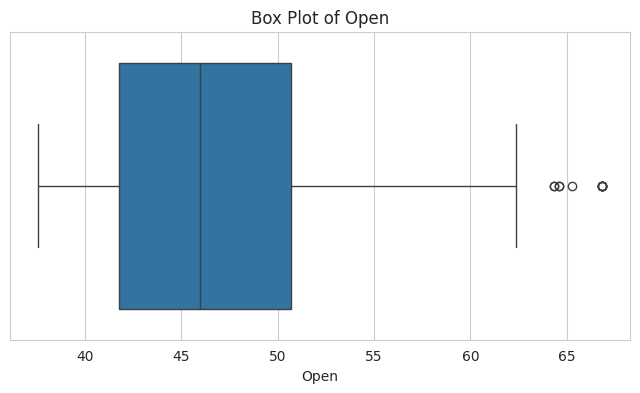

Distribution of High:


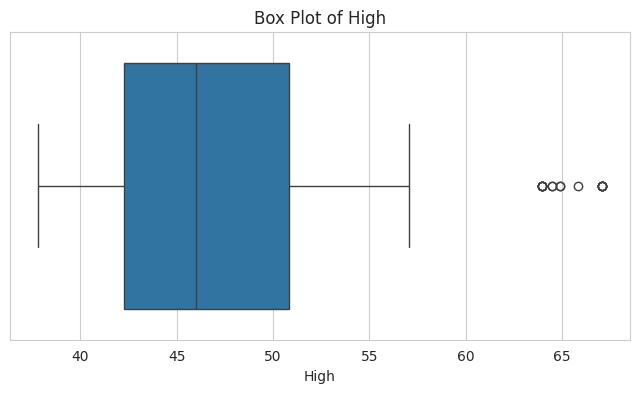

Distribution of Low:


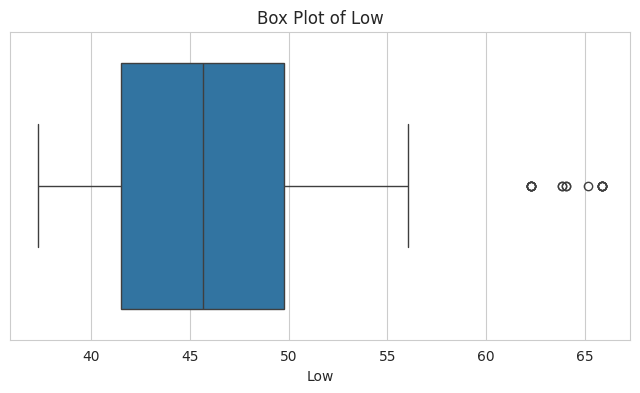

Distribution of Close:


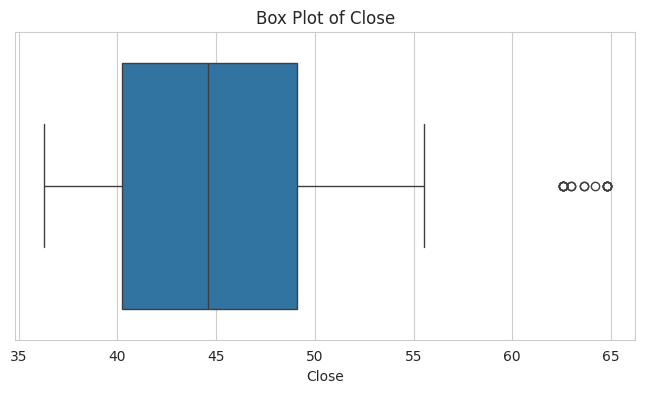

Distribution of Volume:


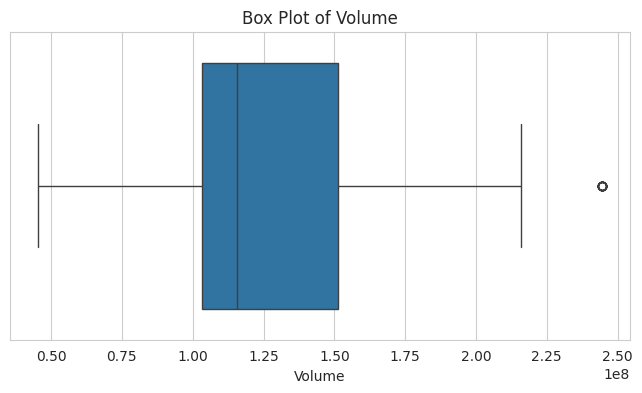

In [ ]:
# Select numerical columns
numerical_cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plot box plots for numerical columns
for col in numerical_cols:
    print(f"Distribution of {col}:")

    # Box plot
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=stock_data[col])
    plt.title(f'Box Plot of {col}')
    plt.xlabel(col)
    plt.show()

*   Most of the price-related columns show right-skewed distributions, which means that while the majority of stock prices fall within a typical range, there are a few days with unusually high prices represented as outliers
*   The box plot of volume shows one major outlier, which could indicate a day of unusually heavy trading activity

##### **Distribution of news content lengths**

Descriptive statistics of News Length:


,News_Length
count,349.000000
mean,48.349570
std,5.717324
min,18.000000
25%,45.000000
50%,49.000000
75%,52.000000
max,60.000000


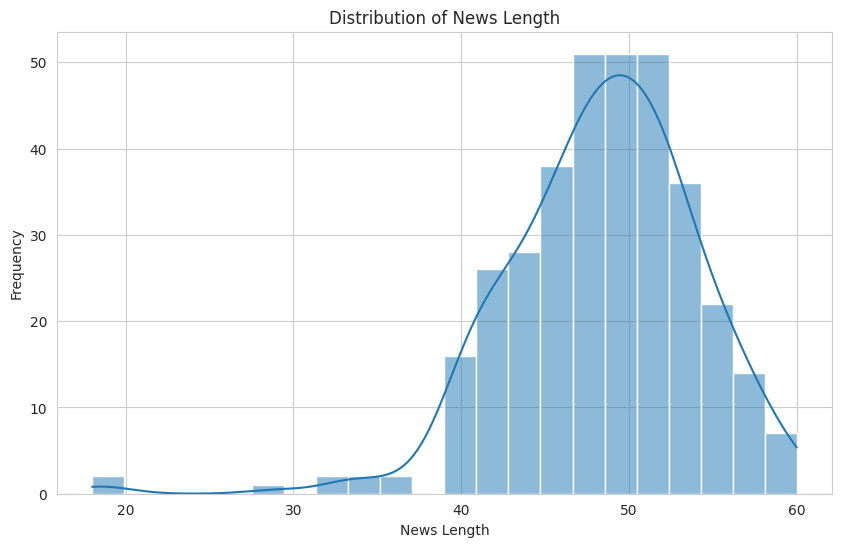


First 5 rows with News Length:


,Date,News,Open,High,Low,Close,Volume,Label,News_Length
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1,45
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1,48
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1,50
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1,49


In [ ]:
# Compute the length of each news article
stock_data['News_Length'] = stock_data['News'].apply(lambda x: len(str(x).split()))

# Display descriptive statistics of the news length
print("Descriptive statistics of News Length:")
display(stock_data['News_Length'].describe())

# Visualize the distribution of news length
plt.figure(figsize=(10, 6))
sns.histplot(stock_data['News_Length'], kde=True)
plt.title('Distribution of News Length')
plt.xlabel('News Length')
plt.ylabel('Frequency')
plt.show()

# Display the first few rows with the new 'News_Length' column
print("\nFirst 5 rows with News Length:")
display(stock_data.head())

*   Most news articles have about the same number of words, around 48. Only a few articles are much shorter or longer than that. So, the length if news is pretty consistent overall.

### **Bivariate Analysis**

* Correlation
* Sentiment Polarity vs Price
* Date vs Price

**Note**: The above points are listed to provide guidance on how to approach bivariate analysis. Analysis has to be done beyond the above listed points to get maximum scores.

##### **Correlation among price variables**

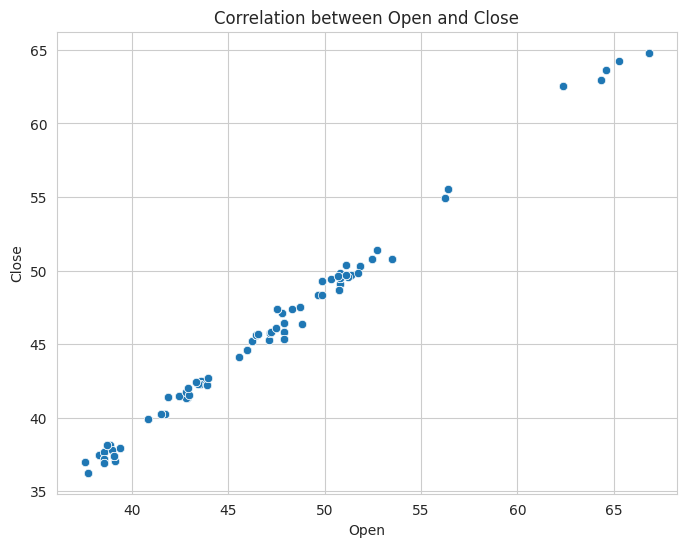

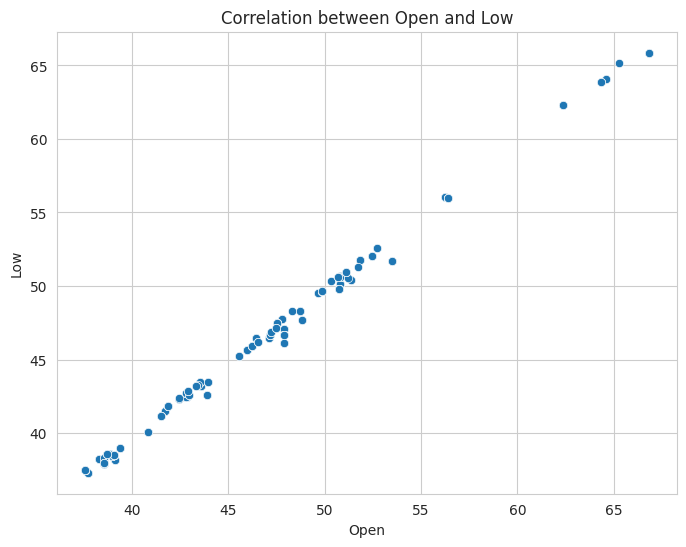

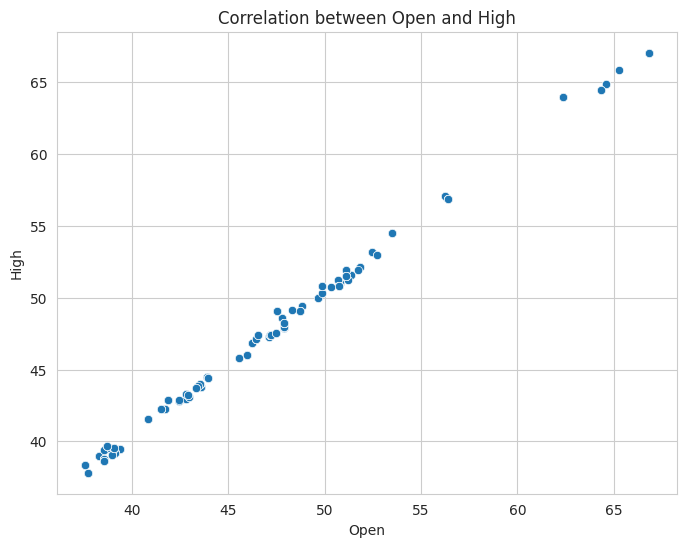

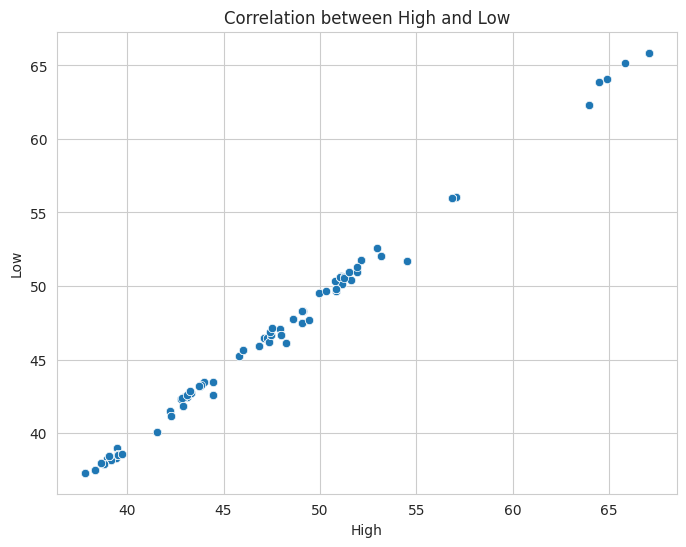

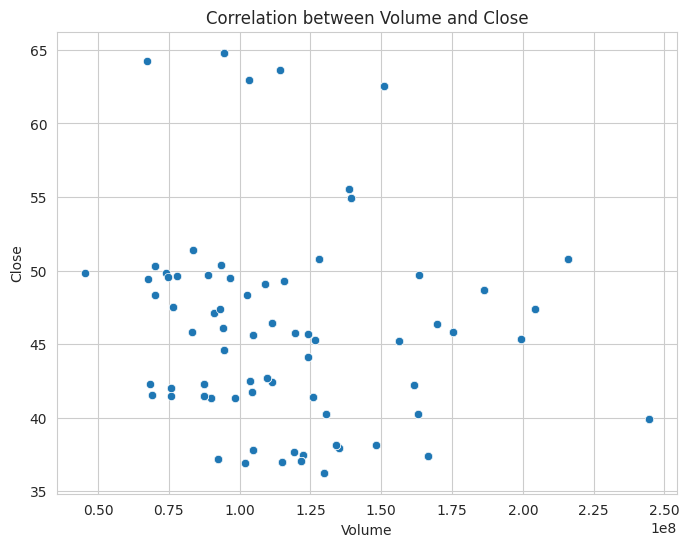

In [ ]:
# Create scatter plots to show correlation between price variables
price_pairs = [('Open', 'Close'), ('Open', 'Low'), ('Open', 'High'), ('High', 'Low'), ('Volume', 'Close')]

#For each iteration, correlation will be plotted by considering each price pair
for x_col, y_col in price_pairs:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=stock_data, x=x_col, y=y_col, )
    plt.title(f'Correlation between {x_col} and {y_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.show()

*   There is a strong positive correlation between various price columns. For example, the relationship between Open and Close prices indicates that as the Opening price increases, the closing price also tends to increase, following by a nearly linear pattern.
*   The scatter plot between Volume and Close shows little or no correlation, which suggests that trading activity is not strongly influenced by the stock's closing price

##### **Relationship between labels and price varaibles**

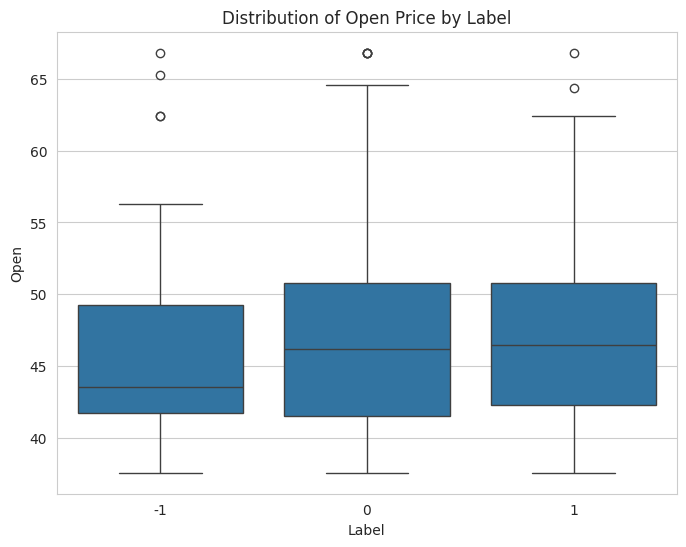

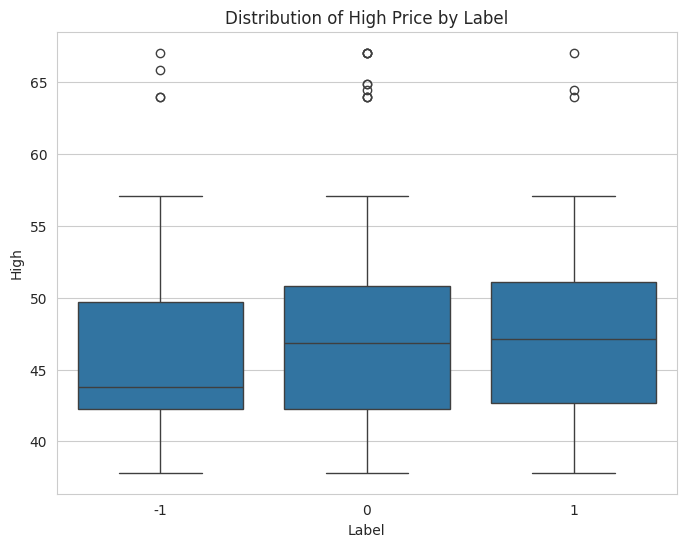

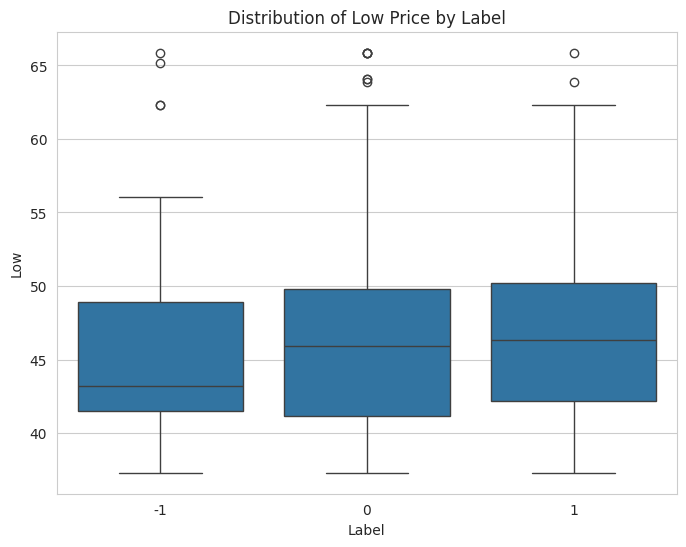

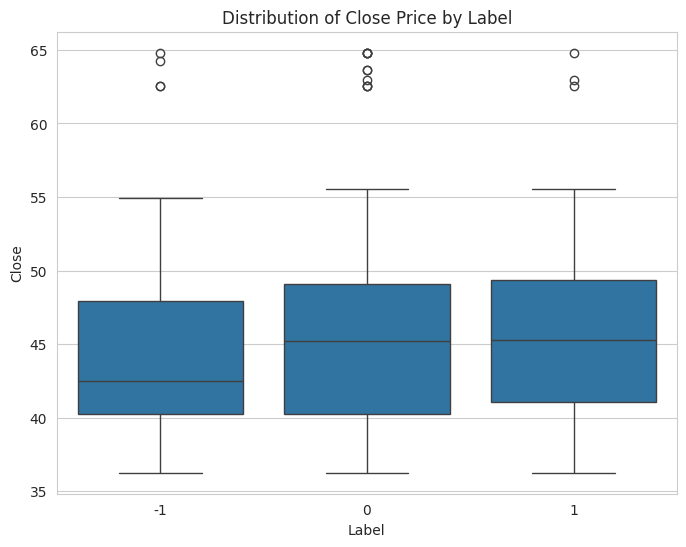

In [ ]:
# Visualize the relationship between Label and price variables
price_cols = ['Open', 'High', 'Low', 'Close']

#For each iteration, consider one price variable and label to plot the box plot
for price_col in price_cols:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Label', y=price_col, data=stock_data)
    plt.title(f'Distribution of {price_col} Price by Label')
    plt.xlabel('Label')
    plt.ylabel(price_col)
    plt.show()


*   The overall distribution and spread of prices are quite similar across all three labels, with outliers present in each category. While sentiment might have a subtle influence on the price levels, it doesn't drastically change the overall price range or variability.



##### **Relationship between labels and % change from Open to Close**

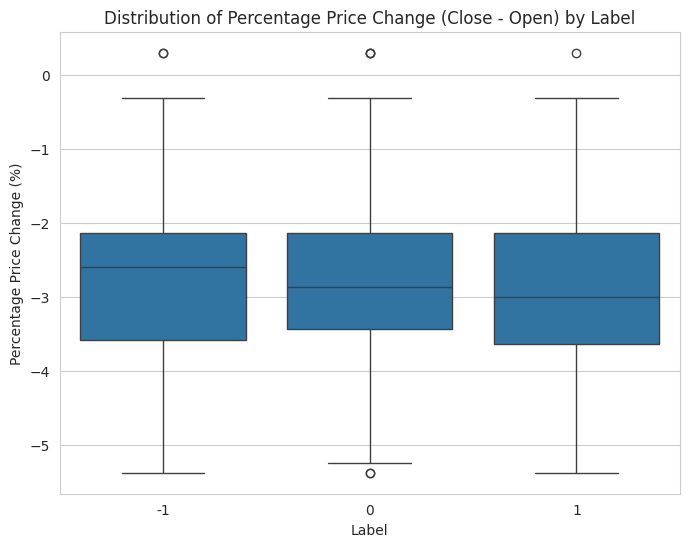

In [ ]:
# Calculate the percentage change from Open to Close
stock_data['Price_Change_Pct'] = ((stock_data['Close'] - stock_data['Open']) / stock_data['Open']) * 100

# Visualize the relationship between Label and Price_Change_Pct
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Price_Change_Pct', data=stock_data)
plt.title('Distribution of Percentage Price Change (Close - Open) by Label')
plt.xlabel('Label')
plt.ylabel('Percentage Price Change (%)')
plt.show()


*  The box plot shows most stocks experienced a drop across all labels. The median % change is negative for all labels, indicating that even neutral or positive labels didn't consistently lead to price increases.

##### **Relationship between labels and news length**

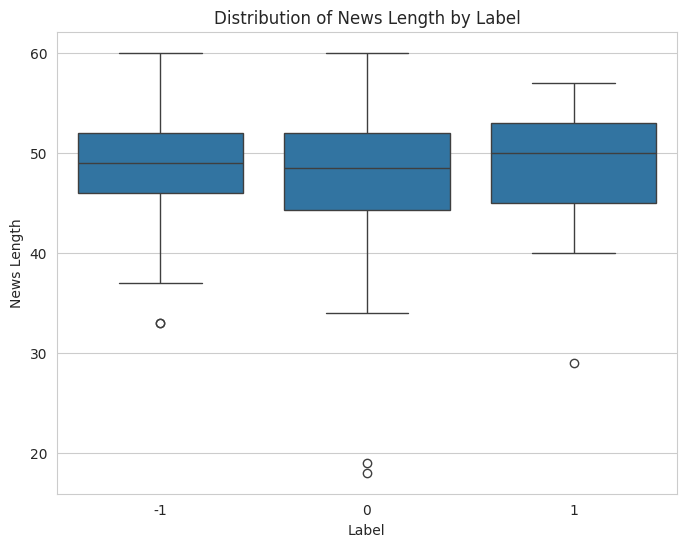

In [ ]:
# Visualize the relationship between Label and News Length
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='News_Length', data=stock_data)
plt.title('Distribution of News Length by Label')
plt.xlabel('Label')
plt.ylabel('News Length')
plt.show()

*   The distribution of news content length is similar across all labels. While news with positive sentiment tends to be slightly longer, the difference is small. This suggests that news lenghth alone may not be a strong indicator of sentiment.

##### **Trends of Average Open, High, Low and Close Prices Over Time**

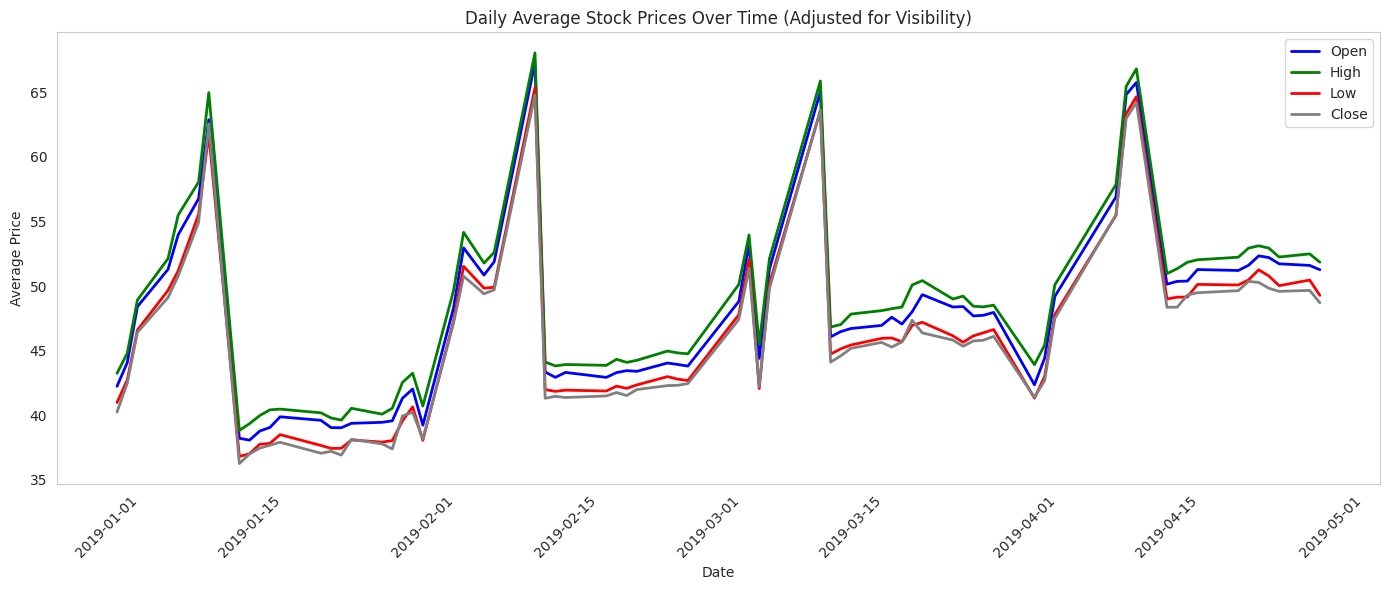

In [ ]:
# Group data by date and take the mean of the Close price for each day
daily_price_data = stock_data.groupby('Date')[['Open', 'High', 'Low', 'Close']].mean().reset_index()

# Sort data by date to ensure correct plotting of time series
daily_price_data_sorted = daily_price_data.sort_values(by='Date')

# Add small offsets to 'Open', 'High', and 'Low' for better visibility
daily_price_data_sorted['Open_offset'] = daily_price_data_sorted['Open'] + 0.5
daily_price_data_sorted['High_offset'] = daily_price_data_sorted['High'] + 1
daily_price_data_sorted['Low_offset'] = daily_price_data_sorted['Low'] - 0.5

#Plot the line plots with different colors
plt.figure(figsize=(14, 6))
sns.lineplot(data=daily_price_data_sorted, x='Date', y='Open_offset', color='blue', linewidth=2, label='Open')
sns.lineplot(data=daily_price_data_sorted, x='Date', y='High_offset', color='green', linewidth=2, label='High')
sns.lineplot(data=daily_price_data_sorted, x='Date', y='Low_offset', color='red', linewidth=2, label='Low')
sns.lineplot(data=daily_price_data_sorted, x='Date', y='Close', color='grey', linewidth=2, label='Close')

plt.title('Daily Average Stock Prices Over Time (Adjusted for Visibility)')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)
plt.legend()
plt.show()

*   The four price lines (Open, High, Low, Close) move almost together, showing very similar patterns. At several points, the prices shoot up sharply and then fall back down just as quickly.
*   These sudden jumps and drops might be linked to important news or events on those days, since the dataset includes news articles and their sentiment.

## **Data Preprocessing**

Preprocessed news content to ensure that the model focuses on important words rather than being distracted by punctuation, special characters or irrelevant tokens. This step improves the learning and enhances the performance of sentiment analysis.

*   Removed punctualtion, special characters and stop words to eliminate noise.
*   Converting text into lowercase to maintain consistency.
*   Splitting the text into individual words/tokens

In [ ]:
#This preprocessing of news helps the model to focus on important words

import re
import nltk
from nltk.corpus import stopwords

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenization
    tokens = text.split()
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the 'News' column
stock_data['Preprocessed_News'] = stock_data['News'].apply(preprocess_text)

# Display the first few rows with the new 'Preprocessed_News' column
print("First 5 rows with Preprocessed News:")
display(stock_data[['News', 'Preprocessed_News']].head())

First 5 rows with Preprocessed News:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,News,Preprocessed_News
0,The tech sector experienced a significant dec...,tech sector experienced significant decline af...
1,Apple lowered its fiscal Q1 revenue guidance ...,apple lowered fiscal q revenue guidance billio...
2,Apple cut its fiscal first quarter revenue fo...,apple cut fiscal first quarter revenue forecas...
3,This news article reports that yields on long...,news article reports yields longdated us treas...
4,Apple's revenue warning led to a decline in U...,apples revenue warning led decline usd jpy pai...


##### **Split the dataset into training and testing datasets**

In [ ]:
# Define features (X-independent variable) and target (y-dependent variable)
X = stock_data['Preprocessed_News']
y = stock_data['Label']

# Split the data into training and testing sets (e.g., 85% train, 15% test). Stratify is used to maintain label distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

# Display the shapes of the resulting splits
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (296,)
Shape of X_test: (53,)
Shape of y_train: (296,)
Shape of y_test: (53,)


## **Word Embeddings**

#### **Generating word embeddings using Word2Vec**

In [ ]:

# Tokenize the preprocessed news text for Word2Vec
# Word2Vec expects a list of lists of words
X_train_tokens = [text.split() for text in X_train]
X_test_tokens = [text.split() for text in X_test]

# Train Word2Vec model on the training data
# vector_size: dimensionality of the word vectors
# window: maximum distance between the current and predicted word within a sentence
# min_count: ignore all words with total frequency lower than this
# workers: number of CPU cores to use
word2vec_model = Word2Vec(sentences=X_train_tokens, vector_size=100, window=5, min_count=1, workers=5)

# Function to get the average word vector for a document
def document_vector(wordlist, model):
    # Remove words not in the vocabulary
    wordlist = [word for word in wordlist if word in model.wv.index_to_key]
    if not wordlist:
        return np.zeros(model.vector_size)
    # Return the average vector of words in the document
    return np.mean(model.wv[wordlist], axis=0)

# Generate document embeddings for training and testing sets and convert to DataFrames
X_train_word2vec = pd.DataFrame([document_vector(tokens, word2vec_model) for tokens in X_train_tokens])
X_test_word2vec = pd.DataFrame([document_vector(tokens, word2vec_model) for tokens in X_test_tokens])


print("Shape of X_train_word2vec:", X_train_word2vec.shape)
print("Shape of X_test_word2vec:", X_test_word2vec.shape)

# Display the length of the vocabulary
print("\nLength of the vocabulary:", len(word2vec_model.wv))

Shape of X_train_word2vec: (296, 100)
Shape of X_test_word2vec: (53, 100)

Length of the vocabulary: 3082


##### **Generating word embeddings using Sentence Transformer**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load a pre-trained Sentence Transformer model using 'all-MiniLM-L6-v2' model
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings for training and testing sets
X_train_sentence_embeddings = sentence_model.encode(X_train.tolist())
X_test_sentence_embeddings = sentence_model.encode(X_test.tolist())

print("Shape of X_train_sentence_embeddings:", X_train_sentence_embeddings.shape)
print("Shape of X_test_sentence_embeddings:", X_test_sentence_embeddings.shape)

Shape of X_train_sentence_embeddings: (296, 384)
Shape of X_test_sentence_embeddings: (53, 384)


## **Sentiment Analysis**

### **Model Evaluation Criterion**

**Note:**  
You can use the helper functions provided below to:
- Plot a **confusion matrix** (`plot_confusion_matrix`)
- Generate key **classification metrics** like accuracy, recall, precision, and F1-score (`model_performance_classification_sklearn`)

These are ready-to-use. However, you’re welcome to explore and write your own evaluation code if you prefer. Feel free to modify or extend these as per your learning goals!

##### **Utility Functions**

In [ ]:
def plot_confusion_matrix(actual, predicted):
    """
    Plot a confusion matrix to visualize the performance of a classification model.

    Parameters:
    actual (array-like): The true labels.
    predicted (array-like): The predicted labels from the model.

    Returns:
    None: Displays the confusion matrix plot.
    """

    # Compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Create a new figure with a specified size
    plt.figure(figsize=(5, 4))

    # Define the labels for the confusion matrix dynamically from the data
    label_list = sorted(list(np.unique(np.concatenate((actual, predicted)))))

    # Plot the confusion matrix using a heatmap with annotations
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', xticklabels=label_list, yticklabels=label_list)

    # Label for the y-axis
    plt.ylabel('Actual')

    # Label for the x-axis
    plt.xlabel('Predicted')

    # Title of the plot
    plt.title('Confusion Matrix')

    # Display the plot
    plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def model_performance_classification_sklearn(actual, predicted):
    """
    Compute various performance metrics for a classification model using sklearn.

    Parameters:
    model (sklearn classifier): The classification model to evaluate.
    predictors (array-like): The independent variables used for predictions.
    target (array-like): The true labels for the dependent variable.

    Returns:
    pandas.DataFrame: A DataFrame containing the computed metrics (Accuracy, Recall, Precision, F1-score).
    """

    # Compute Accuracy
    acc = accuracy_score(actual,predicted)
    # Compute Recall
    recall = recall_score(actual,predicted,average='weighted')
    # Compute Precision
    precision = precision_score(actual,predicted,average='weighted')
    # Compute F1-score
    f1 = f1_score(actual,predicted,average='weighted')

    # Create a DataFrame to store the computed metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": [acc],
            "Recall": [recall],
            "Precision": [precision],
            "F1": [f1],
        }
    )
    # Return the DataFrame with the metrics
    return df_perf

### **Build Random Forest Models using different text embeddings**

##### **Build Random Forest Model using Word2Vec**

Random Forest Model Performance with Word2Vec Embeddings:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Recall,Precision,F1
0,0.45283,0.45283,0.328473,0.365094



Confusion Matrix for Random Forest Model with Word2Vec Embeddings:


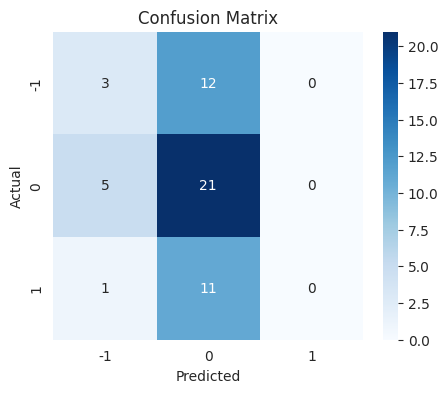


Classification Report for Random Forest Model with Word2Vec Embeddings:
              precision    recall  f1-score   support

          -1       0.33      0.20      0.25        15
           0       0.48      0.81      0.60        26
           1       0.00      0.00      0.00        12

    accuracy                           0.45        53
   macro avg       0.27      0.34      0.28        53
weighted avg       0.33      0.45      0.37        53



In [ ]:
# Build Random Forest model with Word2Vec embeddings
rf_word2vec = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the model
rf_word2vec.fit(X_train_word2vec, y_train)

# Make predictions on the test set
y_pred_word2vec = rf_word2vec.predict(X_test_word2vec)

# Evaluate the model performance
print("Random Forest Model Performance with Word2Vec Embeddings:")
display(model_performance_classification_sklearn(y_test, y_pred_word2vec))

# Plot the confusion matrix
print("\nConfusion Matrix for Random Forest Model with Word2Vec Embeddings:")
plot_confusion_matrix(y_test, y_pred_word2vec)

# Display classification report
print("\nClassification Report for Random Forest Model with Word2Vec Embeddings:")
print(classification_report(y_test, y_pred_word2vec, zero_division=0))

##### **Build Random Forest Model using Sentence Transformer**

Random Forest Model Performance with Sentence Transformer Embeddings:


,Accuracy,Recall,Precision,F1
0,0.509434,0.509434,0.505704,0.443611



Confusion Matrix for Random Forest Model with Sentence Transformer Embeddings:


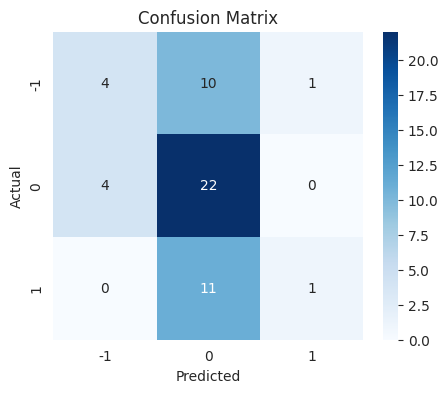


Classification Report for Random Forest Model with Sentence Transformer Embeddings:
              precision    recall  f1-score   support

          -1       0.50      0.27      0.35        15
           0       0.51      0.85      0.64        26
           1       0.50      0.08      0.14        12

    accuracy                           0.51        53
   macro avg       0.50      0.40      0.38        53
weighted avg       0.51      0.51      0.44        53



In [ ]:
# Build Random Forest model with Sentence Transformer embeddings
rf_sentence_transformer = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)

# Train the model
rf_sentence_transformer.fit(X_train_sentence_embeddings, y_train)

# Make predictions on the test set
y_pred_sentence_transformer = rf_sentence_transformer.predict(X_test_sentence_embeddings)

# Evaluate the model performance
print("Random Forest Model Performance with Sentence Transformer Embeddings:")
display(model_performance_classification_sklearn(y_test, y_pred_sentence_transformer))

# Plot the confusion matrix
print("\nConfusion Matrix for Random Forest Model with Sentence Transformer Embeddings:")
plot_confusion_matrix(y_test, y_pred_sentence_transformer)

# Display classification report
print("\nClassification Report for Random Forest Model with Sentence Transformer Embeddings:")
print(classification_report(y_test, y_pred_sentence_transformer))

##### **Build Random Forest Model using Sentence Transformer with adjusted class weights**


I chose this approach to handle class imbalance and improve overall performance metrics

Calculated Class Weights: {-1: 1.1746031746031746, 0: 0.6851851851851852, 1: 1.4509803921568627}

Random Forest Model Performance with Sentence Transformer Embeddings and Class Weights:


,Accuracy,Recall,Precision,F1
0,0.509434,0.509434,0.497186,0.476415



Confusion Matrix for Random Forest Model with Sentence Transformer Embeddings and Class Weights:


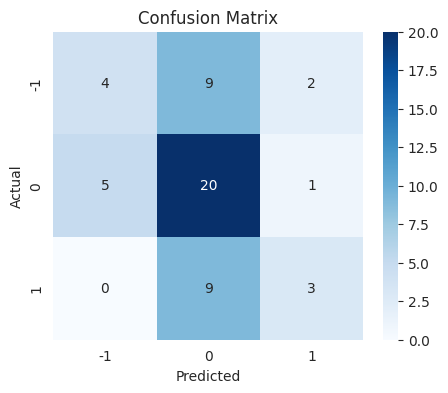


Classification Report for Random Forest Model with Sentence Transformer Embeddings and Class Weights:
              precision    recall  f1-score   support

          -1       0.44      0.27      0.33        15
           0       0.53      0.77      0.62        26
           1       0.50      0.25      0.33        12

    accuracy                           0.51        53
   macro avg       0.49      0.43      0.43        53
weighted avg       0.50      0.51      0.48        53



In [ ]:
from sklearn.utils import compute_class_weight

# Calculate class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Calculated Class Weights:", class_weight_dict)

# Build Random Forest model with Sentence Transformer embeddings and adjusted class weights
rf_sentence_transformer_weighted = RandomForestClassifier(n_estimators=175, max_depth=5, random_state=42, class_weight=class_weight_dict)

# Train the model
rf_sentence_transformer_weighted.fit(X_train_sentence_embeddings, y_train)

# Make predictions on the test set
y_pred_sentence_transformer_weighted = rf_sentence_transformer_weighted.predict(X_test_sentence_embeddings)

# Evaluate the model performance
print("\nRandom Forest Model Performance with Sentence Transformer Embeddings and Class Weights:")
display(model_performance_classification_sklearn(y_test, y_pred_sentence_transformer_weighted))

# Plot the confusion matrix
print("\nConfusion Matrix for Random Forest Model with Sentence Transformer Embeddings and Class Weights:")
plot_confusion_matrix(y_test, y_pred_sentence_transformer_weighted)

# Display classification report
print("\nClassification Report for Random Forest Model with Sentence Transformer Embeddings and Class Weights:")
print(classification_report(y_test, y_pred_sentence_transformer_weighted))

### **Building Neural Network Models using different text embeddings**

Used 2 hidden layers with 64 and 32 neurons with ReLU activation and a softmax output layer, since its multi-class classification. The model was compiled using sparse categorical crossentropy as the loss function because the labels are integer-encoded and this loss would be preferred for multi-class to achieve better training. Trained the model for 100 epochs with a batch size of 16 and a validation split of 0.2

##### **Build Neural Network Model using Word2Vec**


Number of unique classes after indexing: 3
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4843 - loss: 1.0945 - val_accuracy: 0.5667 - val_loss: 1.0730
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5050 - loss: 1.0799 - val_accuracy: 0.5667 - val_loss: 1.0553
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4952 - loss: 1.0653 - val_accuracy: 0.5667 - val_loss: 1.0360
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5309 - loss: 1.0483 - val_accuracy: 0.5667 - val_loss: 1.0204
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4475 - loss: 1.0662 - val_accuracy: 0.5667 - val_loss: 1.0131
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5000 - loss: 1.0524 - val_accuracy: 0.5667 - val_loss: 1.0065
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4592 - loss: 1.0603 - val_accuracy: 0.5667 - val_loss: 1.0104
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4355 - loss: 1.0785 - val_accuracy: 0.5667 - val_loss:

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Recall,Precision,F1
0,0.415094,0.415094,0.318598,0.360262



Confusion Matrix for Neural Network Model with Word2Vec Embeddings:


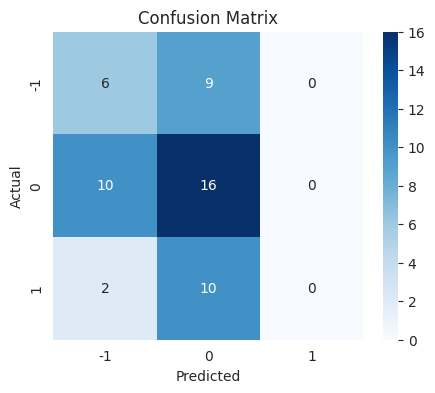


Classification Report for Neural Network Model with Word2Vec Embeddings:
              precision    recall  f1-score   support

          -1       0.33      0.40      0.36        15
           0       0.46      0.62      0.52        26
           1       0.00      0.00      0.00        12

    accuracy                           0.42        53
   macro avg       0.26      0.34      0.30        53
weighted avg       0.32      0.42      0.36        53



In [ ]:

K.clear_session()

# Convert labels to be zero-indexed for sparse_categorical_crossentropy
y_train_indexed = y_train.replace({-1: 0, 0: 1, 1: 2})
y_test_indexed = y_test.replace({-1: 0, 0: 1, 1: 2})

# Determine the number of unique classes
num_classes = len(np.unique(y_train_indexed))
print("Number of unique classes after indexing:", num_classes)

# Build the improved Neural Network model for Word2Vec embeddings
nn_word2vec = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_word2vec.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
nn_word2vec.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
train_word2vec_nn = nn_word2vec.fit(
    X_train_word2vec, y_train_indexed,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)

# Make predictions on the test set
y_pred_prob_word2vec = nn_word2vec.predict(X_test_word2vec)
y_pred_word2vec_nn_indexed = np.argmax(y_pred_prob_word2vec, axis=1)

# Convert predictions back to original labels
y_pred_word2vec_nn = pd.Series(y_pred_word2vec_nn_indexed).replace({0: -1, 1: 0, 2: 1}).values

# Evaluate the model performance
print("\nNeural Network Model Performance with Word2Vec Embeddings:")
display(model_performance_classification_sklearn(y_test, y_pred_word2vec_nn))

# Plot confusion matrix
print("\nConfusion Matrix for Neural Network Model with Word2Vec Embeddings:")
plot_confusion_matrix(y_test, y_pred_word2vec_nn)

# Classification report
print("\nClassification Report for Neural Network Model with Word2Vec Embeddings:")
print(classification_report(y_test, y_pred_word2vec_nn, zero_division=0))

##### **Build Neural Network Model using Sentence Transformer**




Neural Network Model Summary (Sentence Transformer):


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,819 (104.76 KB)

 Trainable params: 26,819 (104.76 KB)

 Non-trainable params: 0 (0.00 B)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step

Neural Network Model Performance with Sentence Transformer Embeddings:


,Accuracy,Recall,Precision,F1
0,0.320755,0.320755,0.327181,0.322575



Confusion Matrix for Neural Network Model with Sentence Transformer Embeddings:


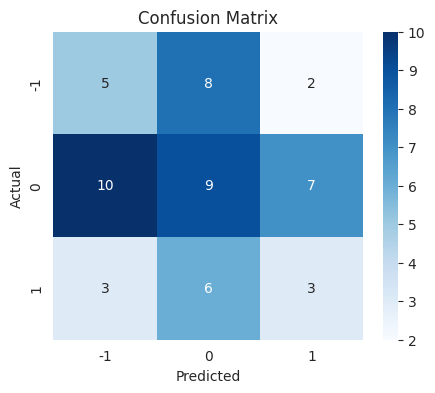


Classification Report for Neural Network Model with Sentence Transformer Embeddings:
              precision    recall  f1-score   support

          -1       0.28      0.33      0.30        15
           0       0.39      0.35      0.37        26
           1       0.25      0.25      0.25        12

    accuracy                           0.32        53
   macro avg       0.31      0.31      0.31        53
weighted avg       0.33      0.32      0.32        53



In [ ]:
# Determine the number of unique classes (still 3)
num_classes = len(np.unique(y_train_indexed))

# Build the Neural Network model for Sentence Transformer embeddings
nn_sentence_transformer = Sequential([

    Dense(64, activation='relu', input_shape=(X_train_sentence_embeddings.shape[1],)),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

# Compile the model
nn_sentence_transformer.compile(optimizer='adam',
                                loss='sparse_categorical_crossentropy',
                                metrics=['accuracy'])

# Display model summary
print("\nNeural Network Model Summary (Sentence Transformer):")
nn_sentence_transformer.summary()

# Train the model
history_sentence_transformer = nn_sentence_transformer.fit(X_train_sentence_embeddings, y_train_indexed,
                                                        epochs=100,
                                                        batch_size=16,
                                                        validation_split=0.2,
                                                        verbose=0)

# Make predictions on the test set
y_pred_prob_sentence_transformer = nn_sentence_transformer.predict(X_test_sentence_embeddings)
y_pred_sentence_transformer_nn_indexed = np.argmax(y_pred_prob_sentence_transformer, axis=1)

# Convert predictions back to original labels for evaluation
y_pred_sentence_transformer_nn = pd.Series(y_pred_sentence_transformer_nn_indexed).replace({0: -1, 1: 0, 2: 1}).values


# Evaluate the model performance
print("\nNeural Network Model Performance with Sentence Transformer Embeddings:")
display(model_performance_classification_sklearn(y_test, y_pred_sentence_transformer_nn))

# Plot the confusion matrix
print("\nConfusion Matrix for Neural Network Model with Sentence Transformer Embeddings:")
plot_confusion_matrix(y_test, y_pred_sentence_transformer_nn)

# Display classification report
print("\nClassification Report for Neural Network Model with Sentence Transformer Embeddings:")
print(classification_report(y_test, y_pred_sentence_transformer_nn))

Used Grid Search Cross Validation to find the best parameters for a Random Forest classifier which tests many possible settings. Model picks the one that gives the highest weighted F1-score, retrains the model with those settings, and then checks how well it performs on unseen test data

##### **Build Random Forest Model using Grid Search Cross Validation** : This code was commented to ensure faster training and evaluation because the execution time of this code block increased to more than 4 minutes.



In [ ]:
"""from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]   # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Classifier with class weights
rf_sentence_transformer_weighted = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_sentence_transformer_weighted, param_grid=param_grid,
                           cv=5, scoring='f1_weighted', n_jobs=-1) # Using weighted F1-score as the scoring metric

# Perform hyperparameter tuning
grid_search.fit(X_train_sentence_embeddings, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best Weighted F1-score from GridSearchCV:", best_score)

# Train the model with the best parameters
best_rf_model = RandomForestClassifier(**best_params, random_state=42, class_weight=class_weight_dict)
best_rf_model.fit(X_train_sentence_embeddings, y_train)

# Make predictions on the test set using the best model
y_pred_best_rf = best_rf_model.predict(X_test_sentence_embeddings)

# Evaluate the best model's performance on the test set
print("\nBest Random Forest Model Performance on Test Set:")
display(model_performance_classification_sklearn(y_test, y_pred_best_rf))

# Plot the confusion matrix for the best model
print("\nConfusion Matrix for Best Random Forest Model:")
plot_confusion_matrix(y_test, y_pred_best_rf)

# Display classification report for the best model
print("\nClassification Report for Best Random Forest Model:")
print(classification_report(y_test, y_pred_best_rf))"""

'from sklearn.model_selection import GridSearchCV\nfrom sklearn.ensemble import RandomForestClassifier\n\n# Define the parameter grid for hyperparameter tuning\nparam_grid = {\n    \'n_estimators\': [100, 200, 300],  # Number of trees in the forest\n    \'max_depth\': [5, 10, 15, None],  # Maximum depth of the tree\n    \'min_samples_split\': [2, 5, 10], # Minimum number of samples required to split an internal node\n    \'min_samples_leaf\': [1, 2, 4]   # Minimum number of samples required to be at a leaf node\n}\n\n# Initialize the Random Forest Classifier with class weights\nrf_sentence_transformer_weighted = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)\n\n# Initialize GridSearchCV\ngrid_search = GridSearchCV(estimator=rf_sentence_transformer_weighted, param_grid=param_grid,\n                           cv=5, scoring=\'f1_weighted\', n_jobs=-1) # Using weighted F1-score as the scoring metric\n\n# Perform hyperparameter tuning\ngrid_search.fit(X_train_senten

### **Model Performance Summary and Final Model Selection**

In [ ]:
# Create a dictionary to store the performance metrics for each model
model_performance_dict = {
    "Random Forest (Word2Vec)": model_performance_classification_sklearn(y_test, y_pred_word2vec).iloc[0],
    "Random Forest (Sentence Transformer)": model_performance_classification_sklearn(y_test, y_pred_sentence_transformer).iloc[0],
    "Random Forest (Sentence Transformer with Class Weights)": model_performance_classification_sklearn(y_test, y_pred_sentence_transformer_weighted).iloc[0],
    "Neural Network (Word2Vec)": model_performance_classification_sklearn(y_test, y_pred_word2vec_nn).iloc[0],
    "Neural Network (Sentence Transformer)": model_performance_classification_sklearn(y_test, y_pred_sentence_transformer_nn).iloc[0],
    #"Best Random Forest (Grid Search)": model_performance_classification_sklearn(y_test, y_pred_best_rf).iloc[0]
}

# Convert the dictionary to a pandas DataFrame
model_performance_df = pd.DataFrame.from_dict(model_performance_dict, orient='index')

# Display the DataFrame
print("Model Performance Comparison:")
display(model_performance_df)


Model Performance Comparison:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Accuracy,Recall,Precision,F1
Random Forest (Word2Vec),0.452830,0.452830,0.328473,0.365094
Random Forest (Sentence Transformer),0.509434,0.509434,0.505704,0.443611
Random Forest (Sentence Transformer with Class Weights),0.509434,0.509434,0.497186,0.476415
Neural Network (Word2Vec),0.415094,0.415094,0.318598,0.360262
Neural Network (Sentence Transformer),0.320755,0.320755,0.327181,0.322575


## **Conclusions and Recommendations**

The goal of this project was to build and evaluate models that classify the sentiment of stock-related news. The dataset was small (349 samples) and imbalanced (49% neutral, 28% negative, 23% positive), which caused most models to predict “neutral” too often, lowering overall performance.

**Random Forest with Word2Vec** and **Neural Network with Word2Vec** both struggled, with low precision and F1, showing heavy bias toward neutral sentiment.

**Random Forest with Sentence Transformer embeddings** improved results, showing better balance in predictions.

**Random Forest with Sentence Transformer and Class Weights** was the best model overall, achieving the highest F1-score (0.476) and best balance between precision and recall.

**Neural Network with Sentence Transformer** didn't performed well, reflecting the difficulty of training effectively on such a small and imbalanced dataset.

**Best Random Forest (Grid Search)** did not improve performance (F1 score - 0.43, Macro F1 - 0.40) when compared to the **Random Forest with Sentence Transformer and Class Weights**. However, it was more time-consuming without a clear performance gain. **Commented this code block since the total execution time increased to more than 4 minutes.**

Overall, **Random Forest models consistently outperformed Neural Networks** in this setup, mainly because neural networks require much larger datasets to capture complex patterns. Also, I believe accuracy alone was not a reliable measure due to class imbalance. F1-score and Macro F1 (treating all classes equally) should be considered for evaluation.

#### **Recommendations**

*   Use **Macro F1** as the main evaluation metric in this scenario.
*   Keep **Random Forest with Sentence Transformer and Class Weights** as the baseline model.
*   Expand the dataset for neural network model to perform better.

<font size=6 color='blue'>Power Ahead</font>
___